# CNN 304
Use a CNN based on Conv1D.

Let it run for 300 epochs in 5-fold CV.

In [25]:
NC_FILENAME='ncRNA.tiny50.fasta'
PC_FILENAME='pcRNA.tiny50.fasta'
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='CNN304'  
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=300
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=64
KERNEL=3
NEURONS=16
DROP=0.25
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [28]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    #embed_layer  = keras.layers.Embedding(
    #    input_dim=VOCABULARY_SIZE, output_dim=4, mask_zero=True)
    SHAPE=(1000,5)  # 1000 time steps, 5 features
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[1000])
    #dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    #cnn.add(embed_layer)
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    cnn.add(clayer4)
    cnn.add(clayer5)
    cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [29]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

## to do:
Stop calling make_kmers() then onehot().
We're only using make_kmers convert ACGT to 1234.
Instead, write an RNA_to_onehot() function.

In [30]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
# TO DO: Fix make_kmers. It takes too long and may not be needed.
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
# print(X_train.shape)
print("First sequence as ints")
print(X_train[0])  
X_train=tools.onehot(X_train)
print("First sequence as onehot")
print(X_train[0])  

Load data from files.
Ready: train_set
Data reshape
First sequence as ints
[4 2 1 4 2 1 3 4 2 2 1 1 1 3 4 2 2 1 3 2 1 3 4 4 3 4 2 2 2 4 2 2 4 3 3 1 1
 4 2 2 3 4 4 3 3 2 4 4 3 2 2 4 2 2 3 3 2 1 4 4 4 4 4 3 3 2 2 2 4 4 3 2 2 4
 4 4 4 1 3 3 3 4 4 3 2 2 1 3 1 4 4 1 1 1 1 3 1 2 1 3 3 1 4 3 2 2 2 1 3 2 4
 1 3 4 4 4 3 1 1 4 4 4 4 1 3 1 4 1 1 1 2 1 1 2 3 1 1 4 1 1 4 4 4 2 3 4 1 3
 2 1 4 1 1 1 4 1 4 3 4 2 2 2 1 1 3 2 4 4 1 3 4 4 4 3 3 3 1 2 1 4 1 2 4 4 1
 4 3 2 4 1 1 1 1 1 1 2 1 4 4 1 4 4 3 3 4 4 3 4 4 4 1 4 2 4 3 1 3 1 4 4 2 1
 3 1 1 4 4 1 1 3 2 1 4 4 4 4 1 4 1 4 4 4 4 1 4 4 4 3 2 4 3 2 2 4 2 4 3 3 2
 2 1 2 2 2 4 1 2 4 2 4 2 4 4 2 2 4 1 1 2 1 2 4 2 4 2 4 2 2 2 4 2 4 2 2 2 1
 3 4 4 4 4 3 4 2 2 3 2 2 4 4 2 2 2 4 3 2 2 4 2 2 4 2 4 4 2 4 3 3 3 3 3 1 3
 4 4 1 3 1 4 2 3 1 3 4 4 3 4 1 1 2 1 1 3 1 1 2 1 4 3 2 2 1 2 4 3 4 2 4 2 3
 2 4 3 3 2 4 3 2 1 3 2 3 4 3 4 3 3 4 2 2 2 2 4 4 1 2 2 1 3 1 3 4 3 1 3 3 1
 4 3 2 3 1 1 3 1 3 1 1 3 3 4 3 3 2 4 3 4 2 4 3 2 1 1 1 2 2 1 3 3 1 1 3 1 3
 1 3 2 2 2 4 2 1 2 2 3 3 

In [31]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1000, 64)          1024      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1000, 64)          12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 500, 64)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 500, 64)           12352     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 500, 64)           12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 250, 64)           0         
___________________________________________________________

Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/300
453/453 [==============================] - 3s 5ms/step - loss: 0.6717 - accuracy: 0.6436 - val_loss: 0.5480 - val_accuracy: 0.7238
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.1.best/assets
Epoch 2/300
453/453 [==============================] - 2s 5ms/step - loss: 0.6057 - accuracy: 0.6807 - val_loss: 0.6000 - val_accuracy: 0.7145
Epoch 3/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5952 - accuracy: 0.7090 - val_loss: 0.5679 - val_accuracy: 0.7275
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.1.best/assets
Epoch 4/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5868 - accuracy: 0.7029 - val_loss: 0.5488 - val_accuracy: 0.7424
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.1.best/assets
Epoch 5/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5771 - accuracy: 0.7029 - val_loss: 0.5627 -

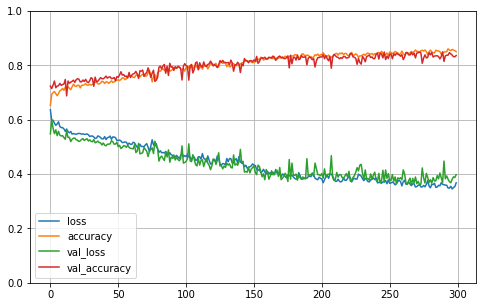

accuracy: 84.98%
COMPILE...
...COMPILED
FIT
Epoch 1/300
453/453 [==============================] - 3s 5ms/step - loss: 0.6082 - accuracy: 0.6755 - val_loss: 0.5553 - val_accuracy: 0.7182
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.2.best/assets
Epoch 2/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5904 - accuracy: 0.6969 - val_loss: 0.5624 - val_accuracy: 0.7145
Epoch 3/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5771 - accuracy: 0.7058 - val_loss: 0.5967 - val_accuracy: 0.7058
Epoch 4/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5757 - accuracy: 0.7073 - val_loss: 0.5812 - val_accuracy: 0.7200
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.2.best/assets
Epoch 5/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5639 - accuracy: 0.7165 - val_loss: 0.5732 - val_accuracy: 0.7089
Epoch 6/300
453/453 [==============================] - 2s 5ms/ste

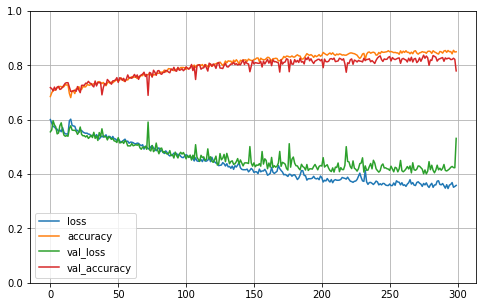

accuracy: 83.74%
COMPILE...
...COMPILED
FIT
Epoch 1/300
453/453 [==============================] - 3s 6ms/step - loss: 0.6751 - accuracy: 0.6278 - val_loss: 0.5860 - val_accuracy: 0.7014
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.3.best/assets
Epoch 2/300
453/453 [==============================] - 2s 5ms/step - loss: 0.6047 - accuracy: 0.6826 - val_loss: 0.5676 - val_accuracy: 0.7176
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.3.best/assets
Epoch 3/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.6951 - val_loss: 0.5703 - val_accuracy: 0.7095
Epoch 4/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5786 - accuracy: 0.7072 - val_loss: 0.5492 - val_accuracy: 0.7250
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.3.best/assets
Epoch 5/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5728 - accuracy: 0.7036 - val_loss: 0.5621 

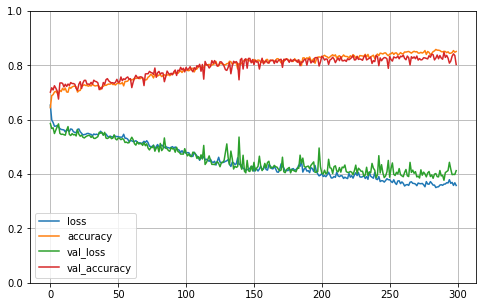

accuracy: 84.85%
COMPILE...
...COMPILED
FIT
Epoch 1/300
453/453 [==============================] - 3s 5ms/step - loss: 0.6259 - accuracy: 0.6769 - val_loss: 0.5584 - val_accuracy: 0.7418
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.4.best/assets
Epoch 2/300
453/453 [==============================] - 2s 5ms/step - loss: 0.6018 - accuracy: 0.6781 - val_loss: 0.5652 - val_accuracy: 0.7225
Epoch 3/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5892 - accuracy: 0.7011 - val_loss: 0.5758 - val_accuracy: 0.7083
Epoch 4/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5956 - accuracy: 0.6739 - val_loss: 0.5882 - val_accuracy: 0.6896
Epoch 5/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5791 - accuracy: 0.7077 - val_loss: 0.5624 - val_accuracy: 0.7064
Epoch 6/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5728 - accuracy: 0.7033 - val_loss: 0.5519 - val_accuracy: 0.7145
Epoch 7/30

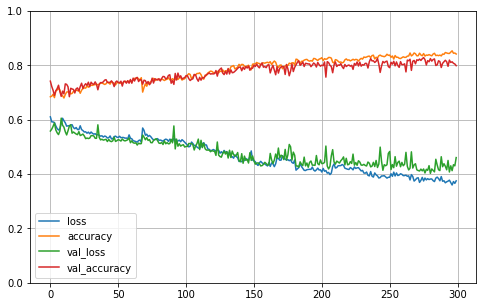

accuracy: 82.87%
COMPILE...
...COMPILED
FIT
Epoch 1/300
453/453 [==============================] - 3s 5ms/step - loss: 0.6343 - accuracy: 0.6579 - val_loss: 0.5469 - val_accuracy: 0.7126
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.5.best/assets
Epoch 2/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5963 - accuracy: 0.6824 - val_loss: 0.5557 - val_accuracy: 0.7151
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.5.best/assets
Epoch 3/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5919 - accuracy: 0.6926 - val_loss: 0.5532 - val_accuracy: 0.7188
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.5.best/assets
Epoch 4/300
453/453 [==============================] - 2s 5ms/step - loss: 0.5883 - accuracy: 0.6987 - val_loss: 0.5433 - val_accuracy: 0.7356
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN304.cv.5.best/assets
Epoch 5/300
453/453 [===========

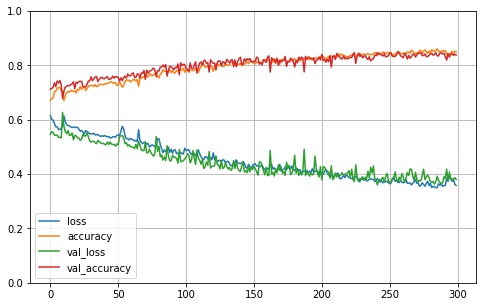

accuracy: 85.04%

5-way Cross Validation mean 84.30% (+/- 0.86%)
Done


In [32]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")